# Advanced Data Science Capstone project

This project is focused on the localization and classification of different skin conditions, based on pictures taken of the condition. The data is gathered from the ISIC Archive, that contains several studies with a total of 20.000+ pictures. 

## Package Management

The data is obtained via ISIC's REST API service, and the service provides a python API, to easier set up ones pipeline. This is installed using the command presented below:

In [ ]:
!pip install isicarchive

     |████████████████████████████████| 51kB 3.8MB/s 
     |████████████████████████████████| 788kB 13.2MB/s 
     |████████████████████████████████| 3.3MB 54.2MB/s 
     |████████████████████████████████| 358kB 52.2MB/s 
ERROR: jupyter-console 5.2.0 has requirement prompt-toolkit<2.0.0,>=1.0.0, but you'll have prompt-toolkit 3.0.5 which is incompatible.
ERROR: google-colab 1.0.0 has requirement ipython~=5.5.0, but you'll have ipython 7.16.1 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython-5.5.0
  Found existing installation: imageio 2.4.1
    Uninstalling imageio-2.4.1:
      Successfully uninstalled imageio-2.4.1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Package import

In [ ]:
from google.colab import files
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
import numpy as np
import os
from numpy import genfromtxt
from keras import backend as K
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout
from keras.models import Model,load_model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.core import Lambda, Flatten, Dense
from keras.utils import Sequence,to_categorical
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam, SGD
from keras.regularizers import l2

from keras.initializers import glorot_uniform, glorot_normal

import isicarchive as isic

import requests  # Import the requests library

from tqdm import tqdm

import cv2

from sklearn.model_selection import train_test_split

import random

from PIL import Image 

from io import BytesIO

import time

%matplotlib inline

Using TensorFlow backend.


### TPU adress setting

In [ ]:
try:
 device_name = os.environ["COLAB_TPU_ADDR"]
 TPU_ADDRESS = "grpc://" + device_name
 print("Found TPU at: {}".format(TPU_ADDRESS))
except KeyError:
 print("TPU not found")

TPU not found


## Extraction from ISIC archive

The first setting is the directories needed for the model checkpoint.

In [ ]:
!rm -r "/content/ISIC/"
!mkdir "/content/ISIC/"

!rm -r "/content/ISIC/modelcheckpoint/"
!mkdir "/content/ISIC/modelcheckpoint/"

!rm -r "/content/ISIC/batches/"
!mkdir "/content/ISIC/batches/"

rm: cannot remove '/content/ISIC/': No such file or directory
rm: cannot remove '/content/ISIC/modelcheckpoint/': No such file or directory
rm: cannot remove '/content/ISIC/batches/': No such file or directory


## ETL 

Settings for API connection:

In [ ]:
#count number of available pictures
api=isic.IsicApi(username="kasperkrasmussen",password="250692KabbeR")

The first function in the ETL is one used to find the total number of pictures available

In [ ]:
#Finds all datasets
ls_ds=api.datasets

n=0
ds_ls=dict({})
for i in ls_ds.keys():
  ds=api.dataset(i)
  if ds.count>0:
    ds_ls[i,ds.id]=ds.count
    n+=ds.count

print("Number of available pictures: " + str(n))

Number of available pictures: 23906


The function below is designed to get a picture based on it's index in the API. Primarily used for testing.

In [ ]:
# gets a picture based on it's index in the API
def getimg(offset,limit):
  # offset kan maks være n-1
  for i in ds_ls:
    params=({"limit":limit,
            "offset":offset})
    
    ls_img=api.image_list(params=params,as_object=True)
    img=[]
    imgmeta=[]

    img_ls=[]
    for i in ls_img:
      i.load_imagedata(keep_rawdata=True)
      img_ls.append(i.data)
      imgmeta = i.meta
      name=i.name
      imgid=i.id
      
  return img_ls,imgmeta,name,imgid

In [ ]:
baseurl="https://isic-archive.com/api/v1/"
def getimg_own(offset,limit):
  endpoint="image"

  url=baseurl+endpoint

  params=({"limit":limit,
          "offset":offset})
  
  x = requests.get(url,params=params)
  
  img_ls=[]
  if x.ok:
    url=url+"/"

    for i in x.json():
      img=requests.get(url+i["_id"]+"/download")

      if img.ok:
        img_arr=np.array(Image.open(BytesIO(img.content)).convert("RGB"))
        img_ls.append(img_arr)

  else:
    print("ER")

  return img_ls

This function is used to get the segmentation given a image ID. This function is used in both testing, as well as production, as it is a vital part in the localization batch generator.

In [ ]:
# Function to get segments for a given feature
# These segments are to be used as bounded boxes in the area of interest identification
# Parameters for getseg function
def getseg(id):
  endpoint="segmentation"
  # gets the list of segments for a picture
  url=baseurl+endpoint
  params={"imageId":id}
  x = requests.get(url,params=params)

  res=None
  segids=[]
  # extract all segment ID's
  if x.ok:
    x=x.json()
    for i in x:
      segids.append(i["_id"])

  #substracts all segments and stacks them all
  url=url+"/"
  segments=[]
  params={"contentDisposition":"attachment"}
  allseg=None
  # extract all segments
  for i in segids:
    x = requests.get(url+i+"/mask",params=params)
    if x.ok:
      x= x.content
      # Converts bytes to numpy array
      img=np.array(Image.open(BytesIO(x)).convert("RGB"))
      segments.append(img)

      # sets up the complete segment
      # to be used to set up a single bounded box for a area of interest
      if allseg is None:
        allseg=np.zeros(segments[0].shape)
        allseg+=img
      else:
        allseg+=img

  # converts segment to int8 format (0-255 format)
  if allseg is not None:
    allseg=np.array(allseg,dtype="uint8")

  return segids,segments,allseg

### Test environment

In [ ]:
# Gets random picture
randimg, randmeta,randname,randid=getimg(random.randint(0,n-1),1)
# Gets random picture's segments
ids,seg,comseg=getseg(randid)

if comseg is None:
  print("!! No segmentation found !!")

In [ ]:
mask=np.where(comseg>0)
x1=np.min(mask[0])
x2=np.max(mask[0])
y1=np.min(mask[1])
y2=np.max(mask[1])

In [ ]:
print(randmeta)

{'acquisition': {'image_type': 'dermoscopic', 'pixelsX': 3024, 'pixelsY': 2016}, 'clinical': {'age_approx': 15, 'benign_malignant': 'benign', 'diagnosis': 'nevus', 'diagnosis_confirm_type': 'single image expert consensus', 'melanocytic': True, 'sex': 'female'}}


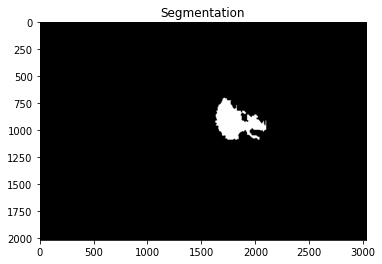

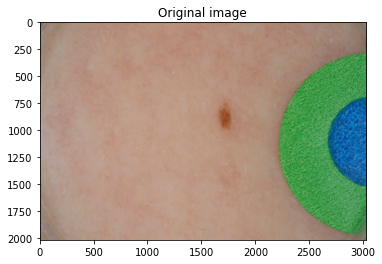

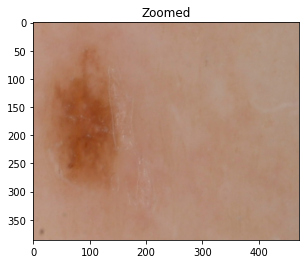

In [ ]:
plt.imshow(comseg)
plt.title("Segmentation")
plt.show()
plt.imshow(randimg[0])
plt.title("Original image")
plt.show()
plt.imshow(randimg[0][x1:x2,y1:y2,:])
plt.title("Zoomed")
plt.show()

In [ ]:
randimg[0].shape

(2016, 3024, 3)

In [ ]:
# if segmentation was found
imw=randmeta['acquisition']['pixelsX']
imh=randmeta['acquisition']['pixelsY']
#Format on comseg [y,x,c]
mask=np.where(comseg>0)
# y bounds
y1=np.min(mask[0])
y2=np.max(mask[0])
#x bounds
x1=np.min(mask[1])
x2=np.max(mask[1])

print("x:")
print((x1,x2))
print("y:")
print((y1,y2))

print("Image size:")
print((imh,imw))

w=x2-x1
h=y2-y1
xcenter=x1+(w/2)
ycenter=y1+(h/2)

y=np.zeros(5)
y[0]=1
y[1]=xcenter/imw
y[2]=ycenter/imh
y[3]=w/imw
y[4]=h/imh
print(y)

x:
(1901, 5729)
y:
(933, 4428)
Image size:
(4431, 6651)
[1.         0.57359796 0.60494245 0.57555255 0.788761  ]


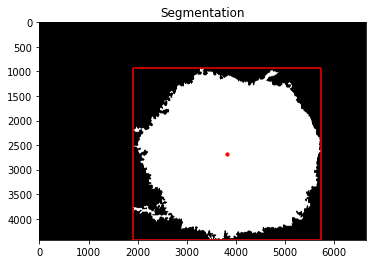

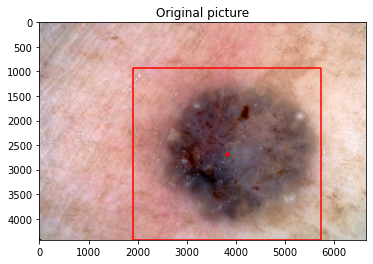

In [ ]:
xhigh=y[1]+(y[3]/2)
xlow=y[1]-(y[3]/2)
yhigh=y[2]+(y[4]/2)
ylow=y[2]-(y[4]/2)

# showing it on segmentation
plt.imshow(comseg)
plt.scatter(x=y[1]*imw, y=y[2]*imh, s=10,c='r')

plt.hlines(yhigh*imh,xlow*imw,xhigh*imw,colors='r')
plt.hlines(ylow*imh,xlow*imw,xhigh*imw,colors='r')

plt.vlines(xhigh*imw,ylow*imh,yhigh*imh,colors='r')
plt.vlines(xlow*imw,ylow*imh,yhigh*imh,colors='r')

plt.title("Segmentation")
plt.show()

# showing it on image
plt.imshow(randimg)
plt.scatter(x=y[1]*imw, y=y[2]*imh, s=10,c='r')

plt.hlines(yhigh*imh,xlow*imw,xhigh*imw,colors='r')
plt.hlines(ylow*imh,xlow*imw,xhigh*imw,colors='r')

plt.vlines(xhigh*imw,ylow*imh,yhigh*imh,colors='r')
plt.vlines(xlow*imw,ylow*imh,yhigh*imh,colors='r')

plt.title("Original picture")
plt.show()

In [ ]:
labels=["actinic keratosis",
          "angiofibroma",
          "fibrous papule",
          "angioma",
          "atypical melanocytic proliferation",
          "basal cell carcinoma",
          "dermatofibroma",
          "lentigo NOS",
          "lentigo simplex",
          "lichenoid keratosis",
          "melanoma",
          "nevus",
          "other",
          "pigmented benign keratosis",
          "scar",
          "seborrheic keratosis",
          "solar lentigo",
          "squamous cell carcinoma",
          "vascular lesion",
          "unknown"]

### Data generator

#### Data generator template

In [ ]:
# data generator for
class DataGenerator(Sequence):
  'Generates data for Keras'
  def __init__(self,list_IDs, labels, batch_size=32, dim=(256,256,3), n_channels=3,
                interpolation=cv2.INTER_AREA,shuffle=True):
    'Initialization'
    #settings
    self.interpolation = interpolation
    self.labels=labels
    self.org_list_IDs=list_IDs

    #parameters (scalar)
    self.dim = dim
    self.batch_size = batch_size
    self.n_channels = n_channels
    self.n_classes = len(labels)
    self.n=len(list_IDs)
    self.shuffle=shuffle

    self.on_epoch_end()

  def __getitem__(self, index):

    # Generate data
    X, y = self.__data_generation(index)

    return X, y

  def __len__(self):
  #Denotes the number of batches per epoch'
   return int(self.n)

  def __data_generation(self,index):
    X = np.empty((self.batch_size, *self.dim, self.n_channels))
    y = np.empty((self.batch_size), dtype=int)

    params=({"limit":self.batch_size,
            "offset":index*self.batch_size})
    
    ls_img=api.image_list(params=params,as_object=True)
    
    j=0
    dist_batch=dict({})
    for im in ls_img:
      try:
        im.load_imagedata(keep_rawdata=True)
        img_reshaped=cv2.resize(im.data,self.dim,interpolation=self.interpolation)
        X[j,:]=img_reshaped
        y[j]=self.labels.index(im.meta["clinical"]["diagnosis"])

        if im.meta["clinical"]["diagnosis"] in dist_batch:
          dist_batch[im.meta["clinical"]["diagnosis"]]+=1
        else:
          dist_batch[im.meta["clinical"]["diagnosis"]]=1

      except:
        pass
      j+=1

    #print(dist_batch)

    return X, to_categorical(y, num_classes=self.n_classes)

  def on_epoch_end(self):
  #Updates indexes after each epoch'
    self.indexes = self.org_list_IDs
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

#### Localization data generator

Data generator used in setting up batches for the training of the model. It is done by getting the image data as a numpy array from the ISIC REST API and resizing it to the given dimension, and using it as the input X. The output Y is found by getting the segmentation map for the picture and extracting the bounded box from the segmentation data. The bounded box is defined as **[bx, by, bw, bh]**, where bx and by is the centeroid of the bounded box in a range from 0 to 1, and bw and bh is the width and height of the bounded box, also in a range from 0 to 1. The range 0-1 is obtained by dividing with the actual width and height of the picture.

The batch generator where each batch is generate based on downloading the image is too slow with 1 second per image. Therefore it should be changed to save the batch locally, to ensure that the same batch isn't loaded twice from ISIC.

In [ ]:
# data generator for
class LocalizationDataGenerator(Sequence):
  'Generates data for Keras'
  def __init__(self,list_IDs, batch_size=32, dim=(256,256,3), n_channels=3,
                interpolation=cv2.INTER_AREA,shuffle=True,subtrain="all",savedir="/content/ISIC/batches"):
    'Initialization'
    #settings
    self.interpolation = interpolation
    self.org_list_IDs=list_IDs

    #parameters (scalar)
    self.dim = dim
    self.outputdim=5

    self.batch_size = batch_size
    self.n_channels = n_channels
    self.n=len(list_IDs)
    self.shuffle=shuffle

    self.on_epoch_end()
    self.endpoint="image/"
    self.url=baseurl+self.endpoint

    self.t0=time.time()
    self.t1=time.time()
    self.savedir=savedir

    self.subtrain=subtrain
  def __getitem__(self, index):

    # Generate data
    self.t0=time.time()
    #print("Time since last data gen: " + str(self.t0-self.t1))
    if os.path.isdir(os.path.join(self.savedir,str(index))):
      #print("Loading excisting")
      #load X
      X=np.load(os.path.join(self.savedir,str(index),"X.npy"))
      #load y
      y=np.load(os.path.join(self.savedir,str(index),"y.npy"))
    else:
      #print("Generating data")
      X, y = self.__data_generation(index)
      # make dir
      if os.path.isdir(os.path.join(self.savedir,str(index)))==False:
        os.mkdir(os.path.join(self.savedir,str(index)))
      # save X
      np.save(os.path.join(self.savedir,str(index),"X"),X)
      # save y
      np.save(os.path.join(self.savedir,str(index),"y"),y)

    self.t1=time.time()
    #print("Data gen time: " + str(self.t1-self.t0))

    if self.subtrain=="all":
      y=[y[:,0],y[:,1:]]
    elif self.subtrain=="class":
      y=y[:,0]
    elif self.subtrain=="reg":
      y=y[:,1:]

    return X, y

  def __len__(self):
  #Denotes the number of batches per epoch'
   return int(self.n)

  def __data_generation(self,index):
    X = np.empty((self.batch_size, *self.dim, self.n_channels),dtype=float)
    # [pc,bx,by,bh,bw]
    y = np.empty((self.batch_size,self.outputdim), dtype=float)

    params=({"limit":self.batch_size,
            "offset":index*self.batch_size})
  
    ls_img = requests.get(self.url,params=params)

    #ls_img=api.image_list(params=params,as_object=True)
    
    j=0
    segadded=0
    segnotadded=0
    dist_batch=dict({})
    for im in ls_img.json():
      # load segmentation
      ids,seg,comseg=getseg(im["_id"])

      #im.load_imagedata(keep_rawdata=True)
      img=requests.get(self.url+im["_id"]+"/download")

      try:
        img_arr=np.array(Image.open(BytesIO(img.content)).convert("RGB"))
        # if segmentation was found
        imh,imw,_=img_arr.shape
        mask=np.where(comseg>0)
        # y bounds
        y1=np.min(mask[0])
        y2=np.max(mask[0])
        #x bounds
        x1=np.min(mask[1])
        x2=np.max(mask[1])

        w=x2-x1
        h=y2-y1
        xcenter=x1+(w/2)
        ycenter=y1+(h/2)

        y[j,0]=1
        y[j,1]=xcenter/imw
        y[j,2]=ycenter/imh
        y[j,3]=w/imw
        y[j,4]=h/imh
        segadded+=1
      except:
        # If no segmentation was found or error in reading binary file
        y[j,0]=1
        y[j,1]=0.5
        y[j,2]=0.5
        y[j,3]=1
        y[j,4]=1
        segnotadded+=1

      img_reshaped=cv2.resize(img_arr,self.dim,interpolation=self.interpolation)

      X[j,:]=img_reshaped
      #Load picture
      j+=1

    #normailzation
    X=X/255

    #print("Segments added: " + str(segadded) + ". Exeptions made: " +str(segnotadded))
    return X, y

  def on_epoch_end(self):
  #Updates indexes after each epoch'
    self.indexes = self.org_list_IDs
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

### Model data setup

In [ ]:
# Parameters
# For object localization following parameters are to be predicted:
# - Center of object compared to picture size (x,y)(0-1)
# - Width of object compared to picture size (0-1)
# - Height of object compared to picture size (0-1)
# (bx,by,bh,bw)
# pc is a indicator of object presence
# output [pc,bx,by,bh,bw,(classes if end to end, softmax function applied on class output)]

#batch size based on post: https://stackoverflow.com/questions/59264851/google-colab-why-is-cpu-faster-than-tpu
#modelling tips: https://medium.com/swlh/bag-of-tricks-for-image-classification-with-convolutional-neural-networks-in-keras-ff99d0ef68f9
params = {'dim': (256,256),
          'batch_size': 64,
          'n_channels': 3,
          'shuffle': True,
          'interpolation':cv2.INTER_AREA,
          'subtrain':'reg',
          'savedir':'/content/drive/My Drive/ISIC/batches/'}

# Datasets
batchindex=np.arange(np.floor(n/params["batch_size"]))
X_train,X_valid=train_test_split(batchindex, test_size=0.33)

# Generators
training_generator = LocalizationDataGenerator(X_train,  **params)
validation_generator = LocalizationDataGenerator(X_valid,  **params)


In [ ]:
print("Number of training batches: " + str(len(X_train)))
print("Number of valid batches: " + str(len(X_valid)))

Number of training batches: 249
Number of valid batches: 124


#### Data generator test

In [ ]:
x,y=training_generator.__getitem__(3)

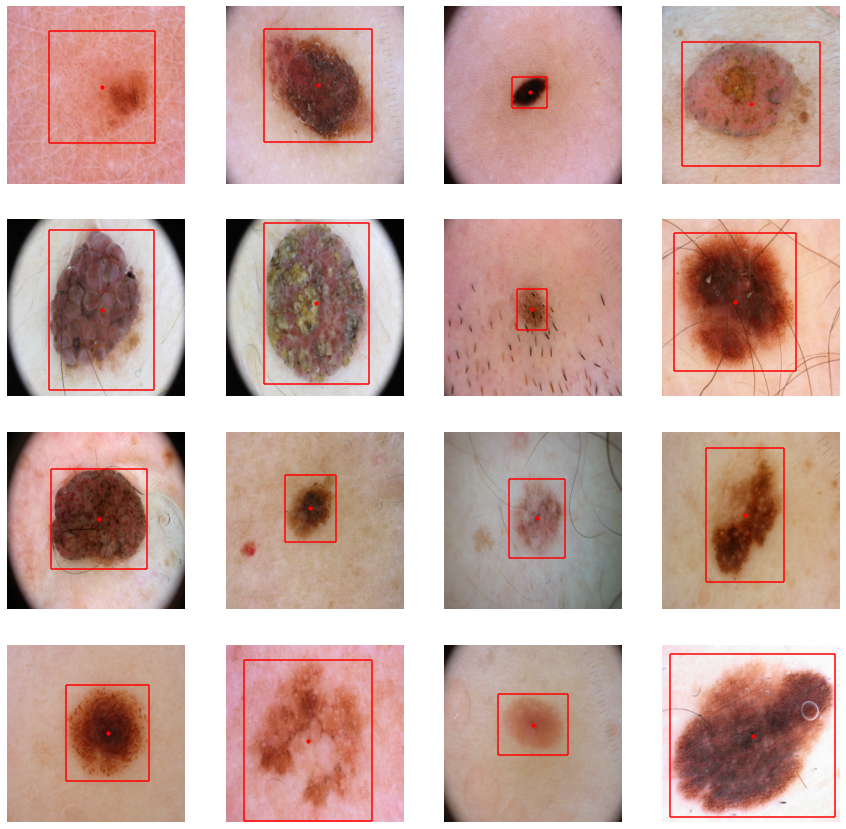

In [ ]:
x_plots=4
y_plots=4
imw=256
imh=256

fig,axs=plt.subplots(x_plots,y_plots,figsize=(15,15))
c=0
for i in range(0,x_plots):
  for j in range(0,y_plots):
    xhigh=y[1][c,0]+(y[1][c,2]/2)
    xlow=y[1][c,0]-(y[1][c,2]/2)
    yhigh=y[1][c,1]+(y[1][c,3]/2)
    ylow=y[1][c,1]-(y[1][c,3]/2)

    # showing it on image
    axs[i,j].imshow(np.array(x[c]*255,dtype='uint8'))
    axs[i,j].scatter(x=y[1][c,0]*imw, y=y[1][c,1]*imh, s=10,c='r')

    axs[i,j].hlines(yhigh*imh,xlow*imw,xhigh*imw,colors='r')
    axs[i,j].hlines(ylow*imh,xlow*imw,xhigh*imw,colors='r')

    axs[i,j].vlines(xhigh*imw,ylow*imh,yhigh*imh,colors='r')
    axs[i,j].vlines(xlow*imw,ylow*imh,yhigh*imh,colors='r')

    axs[i,j].axis('off')

    c+=1

plt.show()

#### Pre generate all batches

In [ ]:
for i in tqdm(X_train):
  training_generator.__getitem__(int(i))

100%|██████████| 249/249 [10:27<00:00,  2.52s/it]


## Model Architecture

In [ ]:
def dermaModel_simple(input_shape = (64, 64, 3), classes = 1):
  # Define the input as a tensor with shape input_shape
  #https://github.com/RockyXu66/Faster_RCNN_for_Open_Images_Dataset_Keras/blob/master/frcnn_train_vgg.ipynb
  X_input = Input(input_shape)
  # block 1
  X = Conv2D(64, 
             kernel_size=1, 
             strides = 1, 
             activation="relu",
             name = 'b1conv1', 
             padding='same',
             kernel_initializer=glorot_uniform(),
             kernel_regularizer=l2(1e-4))(X_input)

  X = Conv2D(64, 
             kernel_size=1, 
             strides = 1, 
             activation="relu", 
             name = 'b1conv2', 
             padding='same',
             kernel_initializer=glorot_uniform(),
             kernel_regularizer=l2(1e-4))(X)


  # block 2
  X = MaxPooling2D(2, strides=(2, 2),padding="same")(X)

  X = Conv2D(128, 
             kernel_size=1, 
             strides = 1, 
             activation="relu", 
             name = 'b2conv1', 
             padding='same',
             kernel_initializer=glorot_uniform(),
             kernel_regularizer=l2(1e-4))(X)

  X = Conv2D(128, 
             kernel_size=1, 
             strides = 1, 
             activation="relu", 
             name = 'b2conv2', 
             padding='same',
             kernel_initializer=glorot_uniform(),
             kernel_regularizer=l2(1e-4))(X)

  # block 3
  X = MaxPooling2D(2, strides=(2, 2),padding="same")(X)

  X = Conv2D(256, 
             kernel_size=1, 
             strides = 1, 
             activation="relu", 
             name = 'b3conv1', 
             padding='same',
             kernel_initializer=glorot_uniform(),
             kernel_regularizer=l2(1e-4))(X)

  X = Conv2D(256, 
             kernel_size=1, 
             strides = 1, 
             activation="relu", 
             name = 'b3conv2', 
             padding='same',
             kernel_initializer=glorot_uniform(),
             kernel_regularizer=l2(1e-4))(X)

  X = Conv2D(256, 
             kernel_size=1, 
             strides = 1, 
             activation="relu", 
             name = 'b3conv3', 
             padding='same',
             kernel_initializer=glorot_uniform(),
             kernel_regularizer=l2(1e-4))(X)

  # block 4
  X = MaxPooling2D(2, strides=(2, 2),padding="same")(X)

  X = Conv2D(512, 
             kernel_size=1, 
             strides = 1, 
             activation="relu", 
             name = 'b4conv1', 
             padding='same',
             kernel_initializer=glorot_uniform(),
             kernel_regularizer=l2(1e-4))(X)

  X = Conv2D(512, 
             kernel_size=1, 
             strides = 1, 
             activation="relu", 
             name = 'b4conv2', 
             padding='same',
             kernel_initializer=glorot_uniform(),
             kernel_regularizer=l2(1e-4))(X)

  X = Conv2D(512, 
             kernel_size=1, 
             strides = 1, 
             activation="relu", 
             name = 'b4conv3', 
             padding='same',
             kernel_initializer=glorot_uniform(),
             kernel_regularizer=l2(1e-4))(X)

  # block 4
  X = MaxPooling2D(2, strides=(2, 2),padding="same")(X)

  X = Conv2D(512, 
             kernel_size=1, 
             strides = 1, 
             activation="relu", 
             name = 'b5conv1', 
             padding='same',
             kernel_initializer=glorot_uniform(),
             kernel_regularizer=l2(1e-4))(X)

  X = Conv2D(512, 
             kernel_size=1, 
             strides = 1, 
             activation="relu", 
             name = 'b5conv2', 
             padding='same',
             kernel_initializer=glorot_uniform(),
             kernel_regularizer=l2(1e-4))(X)

  X = Conv2D(512, 
             kernel_size=1, 
             strides = 1, 
             activation="relu", 
             name = 'b5conv3', 
             padding='same',
             kernel_initializer=glorot_uniform(),
             kernel_regularizer=l2(1e-4))(X)


  # output layer
  X = MaxPooling2D(2, strides=(2, 2))(X)
  
  x_class = Conv2D(classes, 
                   (1, 1), 
                   activation='relu', 
                   name='rpn_out_class',
                   kernel_initializer=glorot_uniform())(X)
  x_regr = Conv2D(4, 
                  (1, 1), 
                  activation='relu', 
                  name='rpn_out_regress',
                  kernel_initializer=glorot_uniform())(X)

  x_class = Flatten()(x_class)
  x_class = Dense(256, 
                  activation='relu', 
                  name='class_fc1',
                  kernel_initializer=glorot_uniform())(x_class)
  x_class = Dense(classes,
                  activation='sigmoid',
                  kernel_initializer=glorot_uniform(),
                  name='out_fc_class')(x_class)

  x_regr = Flatten()(x_regr)
  x_regr = Dense(256, 
                activation='relu', 
                name='reg_fc1',
                kernel_initializer=glorot_uniform())(x_regr)
  x_regr = Dense(4,
                activation='linear',
                kernel_initializer=glorot_uniform(),
                name='out_fc_regr')(x_regr)
  #06-07: ændret activation function for regressions output lag til lineær istedet for sigmoid

    # Create model
  model_rpn = Model(inputs = X_input, outputs = x_regr, name='Model_rpn')
  model_classifier = Model(inputs = X_input, outputs = x_class, name='Model_classifier')
  
  model_all=Model(inputs=X_input,outputs=[x_class,x_regr], name="Model_derma")

  return model_rpn,model_classifier,model_all

In [ ]:
# Design model
modelsavepath="/content/drive/My Drive/ISIC/Current"
savename="{epoch:02d}-{loss:.2f}.hdf5"


checkpoint = ModelCheckpoint(filepath=os.path.join(modelsavepath,savename), 
                             monitor='loss', 
                             verbose=1,
                             save_best_only=True)

model_rpn,model_classifier,model_all=dermaModel_simple((256,256,3))
#define loss function
# skruer learning raten ned, da den ellers stagnerer på omkring 0.08 (.1e-3->.1e-4)
#opt=SGD(
#    learning_rate=1e-4
#)

opt=Adam(
    learning_rate=1e-5
)

# 22-07: changed from regular MSE to reduction='sum' to optimize on the sum of squared error instead of mean of squared error
loss_rpn = tf.keras.losses.MeanSquaredError(reduction='sum')
model_rpn.compile(optimizer=opt, loss=loss_rpn,metrics=['mse'])
model_classifier.compile(optimizer=opt, loss='binary_crossentropy')

# Notes on hyper parameters:
# SGD optimizer med 0.01 virker bedre end Adam med 0.01
# Batch size over 64 er for stor RAM'en sat til rådighed
# steps per epoch bliver skruet væsentligt op kan maks være antallet af batches i X_train (len(X_train))
#   gjort på baggrund af at der ved starten af en ny epoch skette en stigning i tabbet
model_all.compile(optimizer=opt, loss='mean_squared_error')

model_all.summary()

Model: "Model_derma"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
b1conv1 (Conv2D)                (None, 256, 256, 64) 256         input_1[0][0]                    
__________________________________________________________________________________________________
b1conv2 (Conv2D)                (None, 256, 256, 64) 4160        b1conv1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 64) 0           b1conv2[0][0]                    
________________________________________________________________________________________

### Loading pretrained weights

In [ ]:
model_weights = load_model("/content/drive/My Drive/ISIC/Latest/13-07_27-0,07.hdf5")
for i in model_rpn.weights:
  for j in model_weights.weights:
    if j.name[:j.name.rfind("_")]==i.name[:i.name.rfind("_")]:
      if "kernel" in j.name and "kernel" in i.name:
        i=j
      elif "bias" in j.name and "bias" in i.name:
        i=j

In [ ]:
model_w=load_model("/content/drive/My Drive/ISIC/Current/63-0.67.hdf5")
model_rpn.set_weights(model_w.get_weights())

In [ ]:
# Train model on dataset
# steps per epoch ændres fra 128 til 16
history=model_rpn.fit_generator(generator=training_generator,
                    epochs=124, 
                    steps_per_epoch=32,
                    callbacks=[checkpoint],
                    use_multiprocessing=True)

Epoch 1/124
32/32 [==============================] - 63s 2s/step - loss: 0.9413 - mse: 0.0145

Epoch 00001: loss improved from inf to 0.94129, saving model to /content/drive/My Drive/ISIC/Current/01-0.94.hdf5
Epoch 2/124
32/32 [==============================] - 54s 2s/step - loss: 0.7200 - mse: 0.0111

Epoch 00002: loss improved from 0.94129 to 0.71996, saving model to /content/drive/My Drive/ISIC/Current/02-0.72.hdf5
Epoch 3/124
32/32 [==============================] - 81s 3s/step - loss: 0.8474 - mse: 0.0131

Epoch 00003: loss did not improve from 0.71996
Epoch 4/124
32/32 [==============================] - 85s 3s/step - loss: 0.7616 - mse: 0.0117

Epoch 00004: loss did not improve from 0.71996
Epoch 5/124
32/32 [==============================] - 81s 3s/step - loss: 0.9076 - mse: 0.0140

Epoch 00005: loss did not improve from 0.71996
Epoch 6/124
32/32 [==============================] - 82s 3s/step - loss: 0.8331 - mse: 0.0129

Epoch 00006: loss did not improve from 0.71996
Epoch 7/12

### Model inspection

In [ ]:
#https://machinelearningmastery.com/custom-metrics-deep-learning-keras-python/

model_all = load_model("/content/drive/My Drive/ISIC/Latest/13-07_27-0,07.hdf5")
model_all.summary()

Model: "Model_derma"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
b1conv1 (Conv2D)                (None, 256, 256, 64) 256         input_2[0][0]                    
__________________________________________________________________________________________________
b1conv2 (Conv2D)                (None, 256, 256, 64) 4160        b1conv1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 128, 128, 64) 0           b1conv2[0][0]                    
________________________________________________________________________________________

In [ ]:
opt=Adam(
    learning_rate=1e-6
)

model_rpn.compile(optimizer=opt, loss='mean_squared_error')


In [ ]:
model_all.

[None, None]

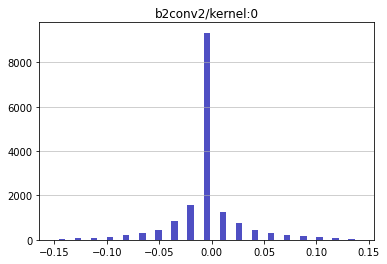

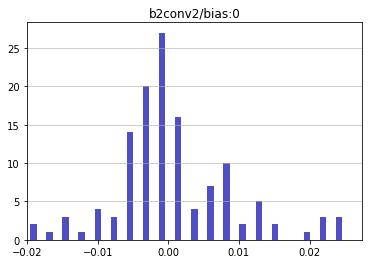

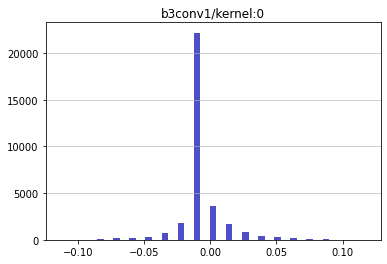

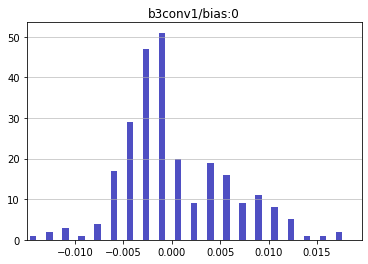

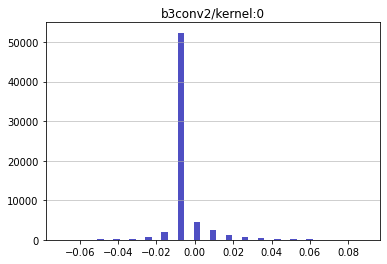

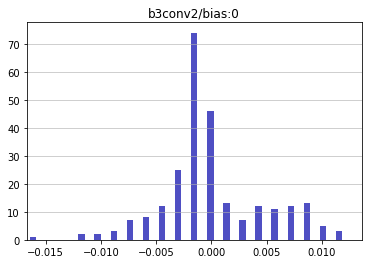

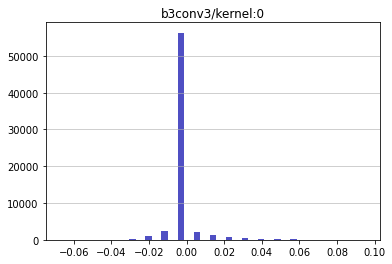

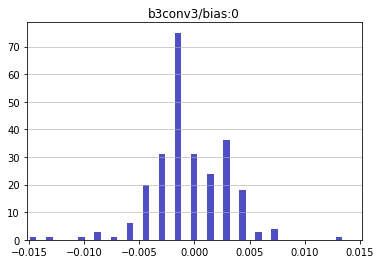

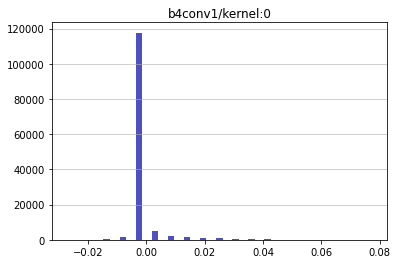

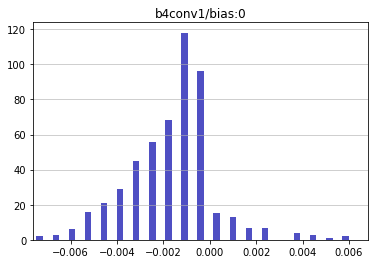

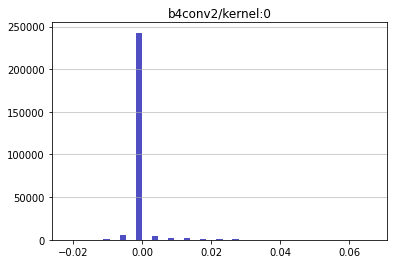

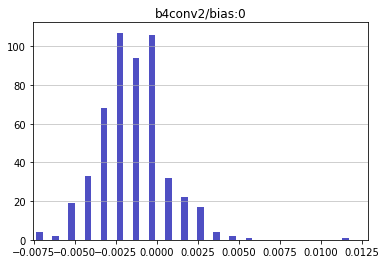

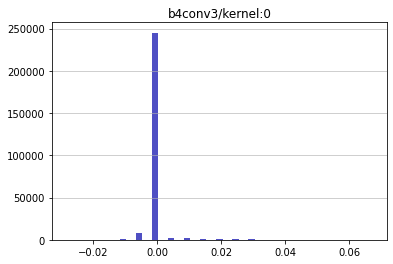

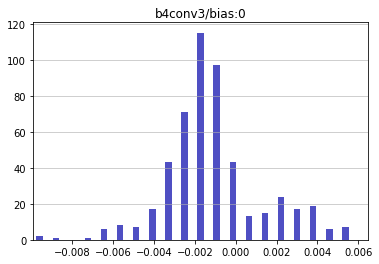

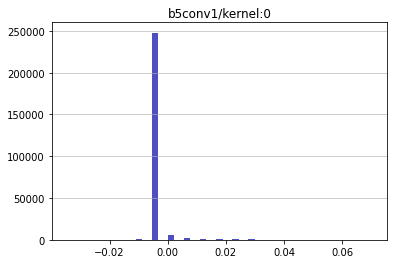

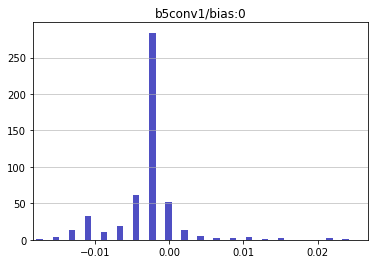

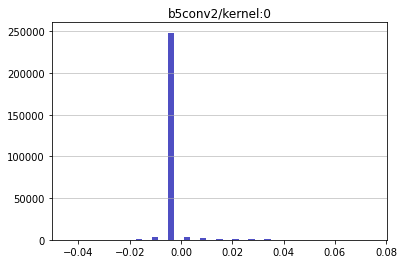

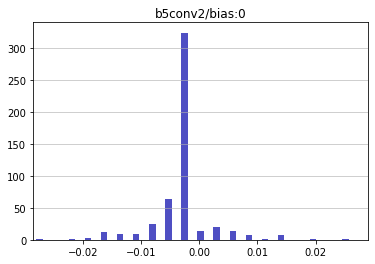

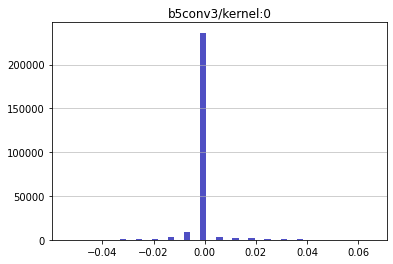

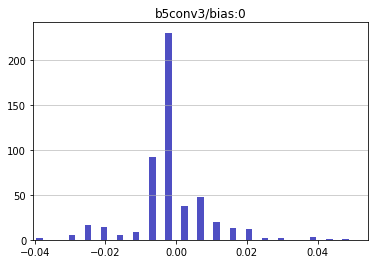

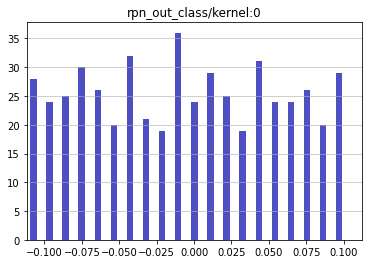

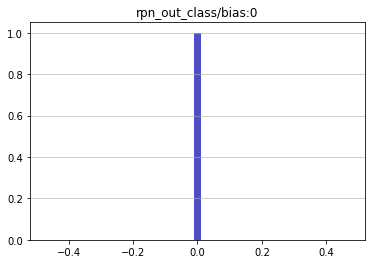

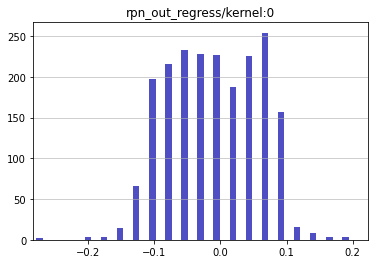

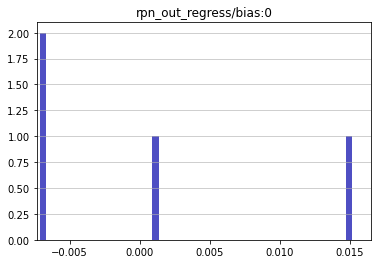

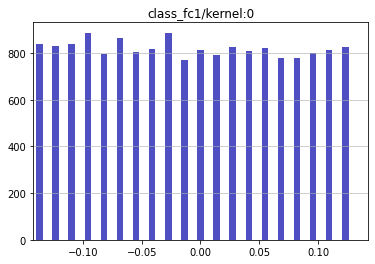

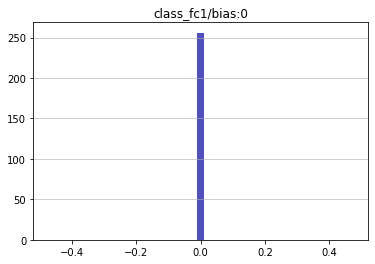

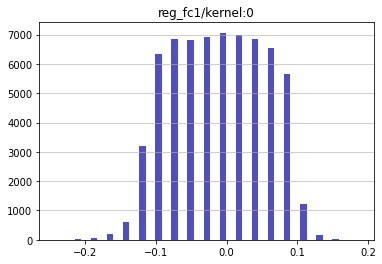

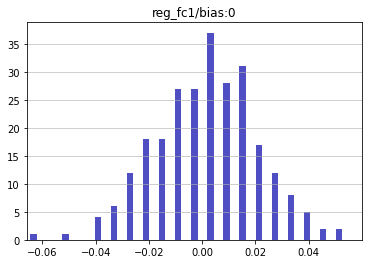

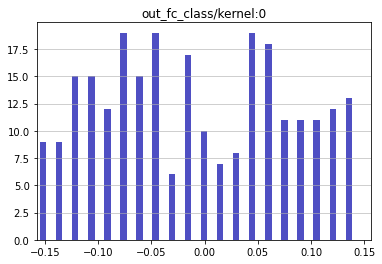

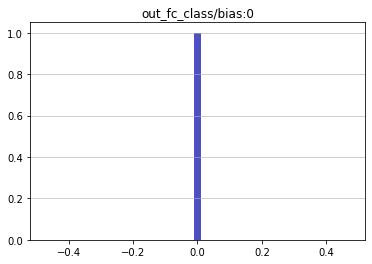

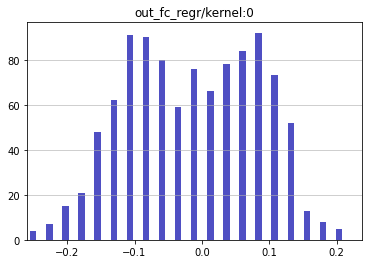

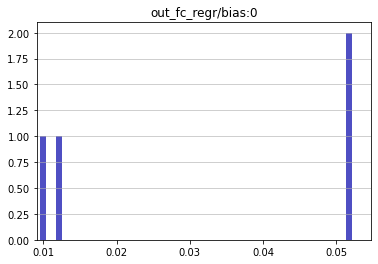

In [ ]:
for i in model_all.weights:
  hist,bin_edges = np.histogram(i.numpy(),bins=20)
  inter=(max(bin_edges)-min(bin_edges))/50

  plt.bar(bin_edges[:-1], hist, color='#0504aa',alpha=0.7,width=inter)
  plt.xlim(min(bin_edges)-abs(inter), max(bin_edges)+(inter))
  plt.title(i.name)
  plt.grid(axis='y', alpha=0.75)
  plt.show()

[array([[0.49901673]], dtype=float32), array([[0.51850927, 0.47187504, 0.72445   , 0.83513397]], dtype=float32)]
[array([[0.49899566]], dtype=float32), array([[0.5185962 , 0.4702987 , 0.7134701 , 0.83337367]], dtype=float32)]
[array([[0.49903792]], dtype=float32), array([[0.520252  , 0.44747406, 0.68778443, 0.80795115]], dtype=float32)]
[array([[0.4992011]], dtype=float32), array([[0.5117183 , 0.49871704, 0.57353073, 0.6437411 ]], dtype=float32)]
[array([[0.49887234]], dtype=float32), array([[0.4134587 , 0.49447745, 0.36421463, 0.40060833]], dtype=float32)]
[array([[0.4988072]], dtype=float32), array([[0.51919115, 0.5428761 , 0.36037973, 0.38874322]], dtype=float32)]
[array([[0.49717268]], dtype=float32), array([[0.529992  , 0.47866836, 0.6317966 , 0.72907656]], dtype=float32)]
[array([[0.49814343]], dtype=float32), array([[0.5085354 , 0.5112785 , 0.2317481 , 0.21918905]], dtype=float32)]
[array([[0.4997431]], dtype=float32), array([[0.47560644, 0.44204777, 0.36244592, 0.4815618 ]], dt

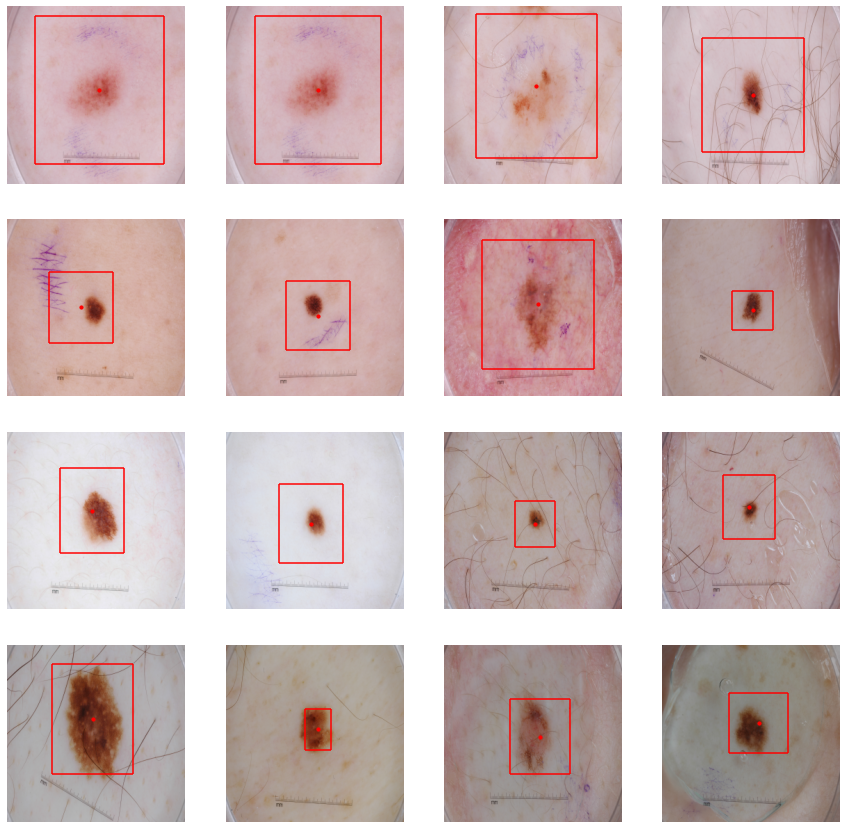

In [ ]:
img_ls=getimg_own(random.randint(0,n-1),16)

x_plots=4
y_plots=4
imw=256
imh=256

fig,axs=plt.subplots(x_plots,y_plots,figsize=(15,15))
c=0
for i in range(0,x_plots):
  for j in range(0,y_plots):
    img=cv2.resize(img_ls[c],(256,256),interpolation=cv2.INTER_AREA)
    norm_img=np.copy(img)/255
    pred=model_all.predict(norm_img.reshape(1,256,256,3))

    xhigh=pred[1][0,0]+(pred[1][0,2]/2)
    xlow=pred[1][0,0]-(pred[1][0,2]/2)
    yhigh=pred[1][0,1]+(pred[1][0,3]/2)
    ylow=pred[1][0,1]-(pred[1][0,3]/2)

    print(pred)

    # showing it on image
    axs[i,j].imshow(img)
    axs[i,j].scatter(x=pred[1][0,0]*imw, y=pred[1][0,1]*imh, s=10,c='r')

    axs[i,j].hlines(yhigh*imh,xlow*imw,xhigh*imw,colors='r')
    axs[i,j].hlines(ylow*imh,xlow*imw,xhigh*imw,colors='r')

    axs[i,j].vlines(xhigh*imw,ylow*imh,yhigh*imh,colors='r')
    axs[i,j].vlines(xlow*imw,ylow*imh,yhigh*imh,colors='r')

    axs[i,j].axis('off')

    c+=1

plt.show()

# Arkiv 06062020

## Første kørsel 

06062020.

def dermaModel(input_shape = (64, 64, 3), classes = 6):
  # Define the input as a tensor with shape input_shape
  X_input = Input(input_shape)

  # Zero-Padding
  X = ZeroPadding2D((3, 3))(X_input)
  

  # Stage 1
  X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((3, 3), strides=(2, 2))(X)

  # output layer
  X = Flatten()(X)
  X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
  
  # Create model
  model = Model(inputs = X_input, outputs = X, name='dermaModel')

  return model


  1/249 [..............................] - ETA: 10:58:32 - loss: 2.9632 - accuracy: 0.0469/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 64 could not be retrieved. It could be because a worker has died.
  UserWarning)
  2/249 [..............................] - ETA: 14:37:17 - loss: 1.5129 - accuracy: 0.5234/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 3 could not be retrieved. It could be because a worker has died.
  UserWarning)
  3/249 [..............................] - ETA: 12:32:32 - loss: 1.0086 - accuracy: 0.6823/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 133 could not be retrieved. It could be because a worker has died.
  UserWarning)
  5/249 [..............................] - ETA: 11:03:03 - loss: 5.2604 - accuracy: 0.7781/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 91 could not be retrieved. It could be because a worker has died.
  UserWarning)
  6/249 [..............................] - ETA: 12:01:27 - loss: 4.3837 - accuracy: 0.8151/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 23 could not be retrieved. It could be because a worker has died.
  UserWarning)
  7/249 [..............................] - ETA: 12:43:42 - loss: 3.7574 - accuracy: 0.8415/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 80 could not be retrieved. It could be because a worker has died.
  UserWarning)
  8/249 [..............................] - ETA: 13:03:56 - loss: 3.2877 - accuracy: 0.8613/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 11 could not be retrieved. It could be because a worker has died.
  UserWarning)
  9/249 [>.............................] - ETA: 13:23:30 - loss: 2.9224 - accuracy: 0.8767/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 143 could not be retrieved. It could be because a worker has died.
  UserWarning)
 10/249 [>.............................] - ETA: 13:41:48 - loss: 2.6329 - accuracy: 0.8875/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 32 could not be retrieved. It could be because a worker has died.
  UserWarning)
 12/249 [>.............................] - ETA: 12:41:25 - loss: 2.3292 - accuracy: 0.8919/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 150 could not be retrieved. It could be because a worker has died.
  UserWarning)
 13/249 [>.............................] - ETA: 12:52:45 - loss: 2.1501 - accuracy: 0.9002/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 161 could not be retrieved. It could be because a worker has died.
  UserWarning)
 14/249 [>.............................] - ETA: 12:32:37 - loss: 14.4510 - accuracy: 0.8817/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 33 could not be retrieved. It could be because a worker has died.
  UserWarning)
 15/249 [>.............................] - ETA: 12:40:44 - loss: 13.4876 - accuracy: 0.8896/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 72 could not be retrieved. It could be because a worker has died.
  UserWarning)
 16/249 [>.............................] - ETA: 12:46:47 - loss: 12.6446 - accuracy: 0.8965/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 183 could not be retrieved. It could be because a worker has died.
  UserWarning)
 17/249 [=>............................] - ETA: 13:26:55 - loss: 18.4856 - accuracy: 0.8833/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 92 could not be retrieved. It could be because a worker has died.
  UserWarning)
 18/249 [=>............................] - ETA: 13:22:55 - loss: 17.7044 - accuracy: 0.8767/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 52 could not be retrieved. It could be because a worker has died.
  UserWarning)
 20/249 [=>............................] - ETA: 12:40:16 - loss: 15.9758 - accuracy: 0.8859/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 139 could not be retrieved. It could be because a worker has died.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/isicarchive/image.py:241: UserWarning: Error loading image data: ('Connection aborted.', OSError(0, 'Error'))
  warnings.warn('Error loading image data: ' + str(e))
 21/249 [=>............................] - ETA: 12:43:43 - loss: 15.2151 - accuracy: 0.8914/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 66 could not be retrieved. It could be because a worker has died.
  UserWarning)
 22/249 [=>............................] - ETA: 12:42:11 - loss: 14.5235 - accuracy: 0.8963/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 39 could not be retrieved. It could be because a worker has died.
  UserWarning)
 23/249 [=>............................] - ETA: 12:42:11 - loss: 13.8920 - accuracy: 0.9008/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 171 could not be retrieved. It could be because a worker has died.
  UserWarning)
 24/249 [=>............................] - ETA: 12:28:24 - loss: 17.8610 - accuracy: 0.8913/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 230 could not be retrieved. It could be because a worker has died.
  UserWarning)
 25/249 [==>...........................] - ETA: 12:17:22 - loss: 19.8956 - accuracy: 0.8781/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 83 could not be retrieved. It could be because a worker has died.
  UserWarning)
 26/249 [==>...........................] - ETA: 12:15:59 - loss: 19.1304 - accuracy: 0.8828/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 137 could not be retrieved. It could be because a worker has died.
  UserWarning)
 28/249 [==>...........................] - ETA: 11:48:06 - loss: 17.7671 - accuracy: 0.8906/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 176 could not be retrieved. It could be because a worker has died.
  UserWarning)
 29/249 [==>...........................] - ETA: 11:37:53 - loss: 19.4496 - accuracy: 0.8761/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 141 could not be retrieved. It could be because a worker has died.
  UserWarning)
 30/249 [==>...........................] - ETA: 11:39:11 - loss: 18.8049 - accuracy: 0.8797/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 215 could not be retrieved. It could be because a worker has died.
  UserWarning)
 31/249 [==>...........................] - ETA: 11:38:41 - loss: 20.9651 - accuracy: 0.8674/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 196 could not be retrieved. It could be because a worker has died.
  UserWarning)
 32/249 [==>...........................] - ETA: 11:39:49 - loss: 29.7629 - accuracy: 0.8433/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 185 could not be retrieved. It could be because a worker has died.
  UserWarning)
 33/249 [==>...........................] - ETA: 12:00:12 - loss: 34.9389 - accuracy: 0.8314/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 43 could not be retrieved. It could be because a worker has died.
  UserWarning)
 35/249 [===>..........................] - ETA: 11:37:32 - loss: 38.3951 - accuracy: 0.8254/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 82 could not be retrieved. It could be because a worker has died.
  UserWarning)
 36/249 [===>..........................] - ETA: 11:35:31 - loss: 37.3286 - accuracy: 0.8303/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 24 could not be retrieved. It could be because a worker has died.
  UserWarning)
 37/249 [===>..........................] - ETA: 11:33:40 - loss: 36.3201 - accuracy: 0.8345/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 100 could not be retrieved. It could be because a worker has died.
  UserWarning)
 38/249 [===>..........................] - ETA: 11:31:43 - loss: 35.3643 - accuracy: 0.8388/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 34 could not be retrieved. It could be because a worker has died.
  UserWarning)
 39/249 [===>..........................] - ETA: 11:29:20 - loss: 34.4575 - accuracy: 0.8429/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 126 could not be retrieved. It could be because a worker has died.
  UserWarning)
 40/249 [===>..........................] - ETA: 11:27:42 - loss: 33.5992 - accuracy: 0.8465/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 78 could not be retrieved. It could be because a worker has died.
  UserWarning)
 42/249 [====>.........................] - ETA: 11:06:44 - loss: 33.4197 - accuracy: 0.8460/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 125 could not be retrieved. It could be because a worker has died.
  UserWarning)
 43/249 [====>.........................] - ETA: 11:05:17 - loss: 32.7381 - accuracy: 0.8434/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 48 could not be retrieved. It could be because a worker has died.
  UserWarning)
 45/249 [====>.........................] - ETA: 10:46:50 - loss: 31.7049 - accuracy: 0.8375/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 36 could not be retrieved. It could be because a worker has died.
  UserWarning)
 46/249 [====>.........................] - ETA: 10:47:08 - loss: 31.0227 - accuracy: 0.8397/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 138 could not be retrieved. It could be because a worker has died.
  UserWarning)
 48/249 [====>.........................] - ETA: 10:32:22 - loss: 30.3548 - accuracy: 0.8389/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 69 could not be retrieved. It could be because a worker has died.
  UserWarning)
 49/249 [====>.........................] - ETA: 10:32:12 - loss: 29.7392 - accuracy: 0.8412/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 163 could not be retrieved. It could be because a worker has died.
  UserWarning)
 50/249 [=====>........................] - ETA: 10:25:12 - loss: 29.9994 - accuracy: 0.8378/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 85 could not be retrieved. It could be because a worker has died.
  UserWarning)
 52/249 [=====>........................] - ETA: 10:12:06 - loss: 29.8917 - accuracy: 0.8314/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 203 could not be retrieved. It could be because a worker has died.
  UserWarning)
 53/249 [=====>........................] - ETA: 10:15:04 - loss: 30.1389 - accuracy: 0.8196/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 54 could not be retrieved. It could be because a worker has died.
  UserWarning)
 54/249 [=====>........................] - ETA: 10:14:29 - loss: 29.8462 - accuracy: 0.8061/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 156 could not be retrieved. It could be because a worker has died.
  UserWarning)
 55/249 [=====>........................] - ETA: 10:07:48 - loss: 30.0303 - accuracy: 0.7980

# Arkiv ny model